In [1]:
import numpy as np
import kernelforge
from kernelforge import inverse_distance_upper, kernel_symm, kernel_asymm, inverse_distance_upper_and_jacobian
import matplotlib.pyplot as plt
import gc
from time import time
from scipy.stats import pearsonr
from kernelforge._kernels import rbf_hessian_full_tiled_gemm, rbf_hessian_full_tiled_gemm_sym
import sys
from kernelforge import _kernels
from time import time
from kernelforge._kernels import solve_cholesky

In [2]:
train = np.load("/home/andersx/dev/laptop-qml/kitchen-sink-qml/data/ethanol_ccsd_t-train.npz")
X = np.asarray([inverse_distance_upper(r) for r in train["R"]])
y = train["E"].flatten()
offset = y.mean()
y -= offset

In [3]:
test = np.load("/home/andersx/dev/laptop-qml/kitchen-sink-qml/data/ethanol_ccsd_t-test.npz")
Xp = np.asarray([inverse_distance_upper(r) for r in test["R"][:999]])
Yt = test["E"][:999].flatten() - offset
Xp.shape

(999, 36)

In [4]:
dX = np.asarray([inverse_distance_upper_and_jacobian(r)[1] for r in train["R"]])
dX.shape

(1000, 36, 27)

In [5]:
dXp = np.asarray([inverse_distance_upper_and_jacobian(r)[1] for r in test["R"][:999]])
dXp.shape

(999, 36, 27)

In [6]:
sigma = 1.0
alpha = -1/(2*sigma**2)
diago = 1e-6
print(alpha, sigma)

-0.5 1.0


In [7]:
K = kernel_symm(X, alpha)
L = np.tril(K)
K = L + L.T - np.diag(np.diag(L))
np.fill_diagonal(K, K.diagonal() + diago)

In [8]:
reg = np.linalg.solve(K, y)
reg[:10]

array([-129734.35553753,  -68820.19875135,  -60929.16205069,
          9805.58642459,  -89020.54235524,  -13861.50093359,
         -1031.34845551,    2277.240965  ,   12258.93092979,
         37691.15239637])

In [9]:
# Change layout
Kp = kernel_asymm(Xp, X, alpha)
Yp = (Kp @ reg).flatten()

RMSE = 1.0387116612452842
PearsonRResult(statistic=np.float64(0.9756610190849834), pvalue=np.float64(0.0))


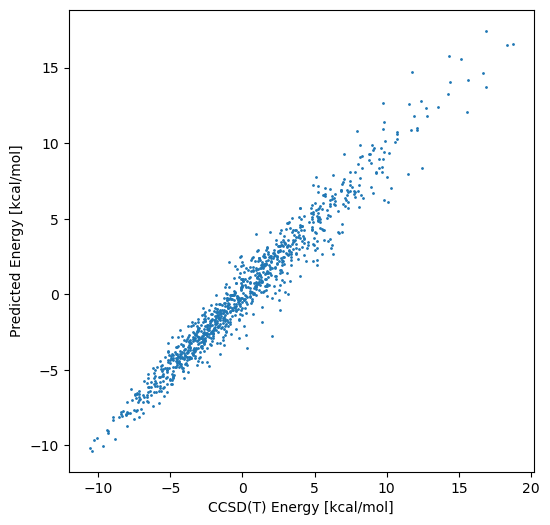

In [10]:
rmse = np.sqrt(np.mean(np.square(Yt - Yp)))
res = pearsonr(Yt, Yp)
print(f"RMSE = {rmse}")
print(res)
fig = plt.figure(figsize=(6,6))
plt.xlabel("CCSD(T) Energy [kcal/mol]")
plt.ylabel("Predicted Energy [kcal/mol]")
plt.scatter(Yt, Yp, s=1)

In [11]:
t_start = time()
dK = _kernels.gaussian_jacobian_batch(Xp, dXp, X, sigma)
t_end = time()
print(t_end - t_start)
Fp = dK @ reg
Fp.reshape(-1,3)

0.08077526092529297


array([[-27.59895495,   4.49002049, -16.60156596],
       [-20.56901531,  -3.81708134,  23.00712685],
       [  5.71377178,  15.19970055,  14.53243116],
       ...,
       [-12.56702899,   8.40567977,   5.60531111],
       [ 24.12541246,  -1.52158993,  -0.32145231],
       [-17.91244469,   1.84340812, -30.12658421]], shape=(8991, 3))

RMSE = 5.33 kcal/mol/Å
PearsonRResult(statistic=np.float64(0.9809921371215073), pvalue=np.float64(0.0))


Text(0, 0.5, 'Predicted Force [kcal/mol/Å]')

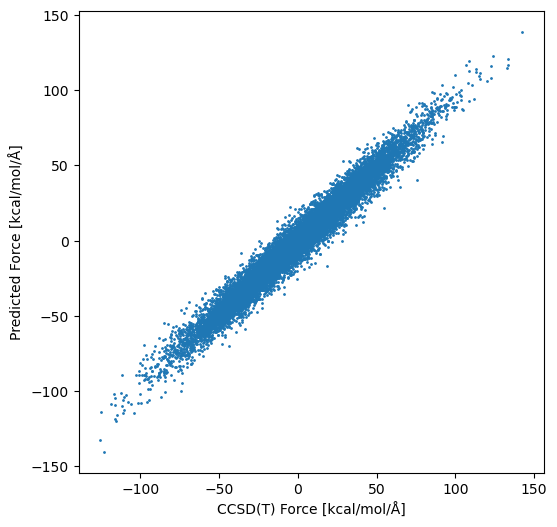

In [12]:
fig = plt.figure(figsize=(6,6))
plt.scatter(
    test["F"].flatten()[:999*9*3],#[:1000],
    -Fp.flatten(),
    s=1
)
res = pearsonr(test["F"].flatten()[:999*9*3], -Fp.flatten())
rmse = np.sqrt(np.mean(np.square(test["F"].flatten()[:999*9*3] + Fp.flatten())))

print(f"RMSE = {rmse:.2f} kcal/mol/Å")
print(res)
plt.xlabel("CCSD(T) Force [kcal/mol/Å]")
plt.ylabel("Predicted Force [kcal/mol/Å]")

In [16]:
t_start = time()
H = rbf_hessian_full_tiled_gemm(X, dX, X,dX, sigma)
# H_symm = rbf_hessian_full_tiled_gemm_sym(X, dX, sigma)
t_end = time()
print(t_end - t_start)


1.8892765045166016


In [18]:
t_start = time()
# H = rbf_hessian_full_tiled_gemm(X, dX, X,dX, sigma)
H_symm = rbf_hessian_full_tiled_gemm_sym(X, dX, sigma, 1)
t_end = time()
print(t_end - t_start)
# H

1.045048475265503


In [15]:
yf = train["F"].flatten()
yf.shape

(27000,)

In [17]:
#np.fill_diagonal(H, H.diagonal() + diago)
H_solve = H_symm.copy()
for i in range(H_solve.shape[0]):
    H_solve[i,i] += 1e-10
t_start = time()
reg = solve_cholesky(H_solve, yf)
t_end = time()
print(t_end - t_start)
reg[:10]

17.077141046524048


array([-2779162.28221227,  5712493.31768169,  2399567.21538117,
         865287.77894768,   881923.55464751,  -773464.73069526,
       -2250307.29823966,  7958283.31814402,  8277812.10212923,
        1915503.45693406])

In [18]:
print(sys.getrefcount(H))   # includes the temporary ref from getrefcount
for obj in gc.get_referrers(H):
    print(type(obj))
del H

2
<class 'dict'>


In [19]:
t_start = time()
Hp = rbf_hessian_full_tiled_gemm(Xp, dXp, X,dX, sigma)
t_end = time()
print(t_end - t_start)
# Hp

1.4514505863189697


In [20]:
Fpp = Hp @ reg
Fpp

array([32.03874642, -0.84056879, 25.96815754, ..., 20.37115493,
       -0.43253272, 29.91474755], shape=(26973,))

In [21]:
print(sys.getrefcount(Hp))   # includes the temporary ref from getrefcount
for obj in gc.get_referrers(Hp):
    print(type(obj))
del Hp

2
<class 'dict'>


RMSE = 1.19 kcal/mol/Å
PearsonRResult(statistic=np.float64(0.9990579771753654), pvalue=np.float64(0.0))


Text(0, 0.5, 'Predicted Force [kcal/mol/Å]')

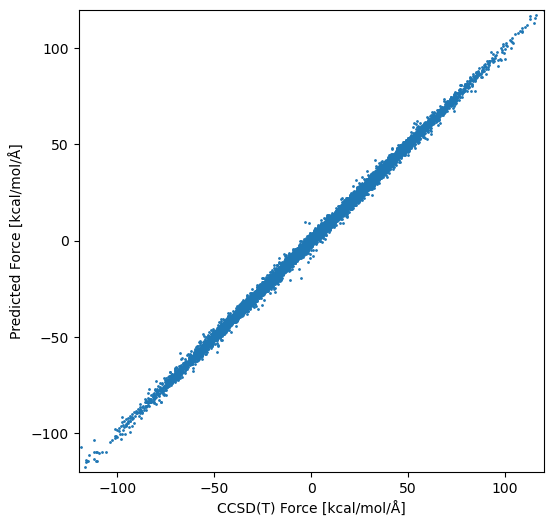

In [22]:
fig = plt.figure(figsize=(6,6))
plt.scatter(
    test["F"][:999].flatten(),#[:1000],
    Fpp.flatten(),
    s=1
)
res = pearsonr(test["F"][:999].flatten(), Fpp.flatten())
rmse = np.sqrt(np.mean(np.square(test["F"][:999].flatten() - Fpp.flatten())))
print(f"RMSE = {rmse:.2f} kcal/mol/Å")
print(res)
plt.xlim(-120,120)
plt.ylim(-120,120)
plt.xlabel("CCSD(T) Force [kcal/mol/Å]")
plt.ylabel("Predicted Force [kcal/mol/Å]")